SGD - Epoch 1 loss: 0.34208737964531394
SGD - Epoch 2 loss: 0.06708169150660669
SGD - Epoch 3 loss: 0.0486749055710232
SGD - Epoch 4 loss: 0.038134266142554676
SGD - Epoch 5 loss: 0.031376708751737474
SGD - Epoch 6 loss: 0.02522663792545561
SGD - Epoch 7 loss: 0.022186635151225105
SGD - Epoch 8 loss: 0.020125792791232538
SGD - Epoch 9 loss: 0.016503351816405283
SGD - Epoch 10 loss: 0.014967438391228799
SGD - Accuracy: 98.9%
AdaDelta - Epoch 1 loss: 0.013803958114899838
AdaDelta - Epoch 2 loss: 0.013791049800976465
AdaDelta - Epoch 3 loss: 0.013800779677913795
AdaDelta - Epoch 4 loss: 0.013791054872408125
AdaDelta - Epoch 5 loss: 0.01379089171144387
AdaDelta - Epoch 6 loss: 0.013792666369519759
AdaDelta - Epoch 7 loss: 0.013794483030419066
AdaDelta - Epoch 8 loss: 0.013793351786364844
AdaDelta - Epoch 9 loss: 0.013793166985531354
AdaDelta - Epoch 10 loss: 0.013799228076173028
AdaDelta - Accuracy: 98.9%
NAG - Epoch 1 loss: 0.013849211322265737
NAG - Epoch 2 loss: 0.013785286670654212
NAG

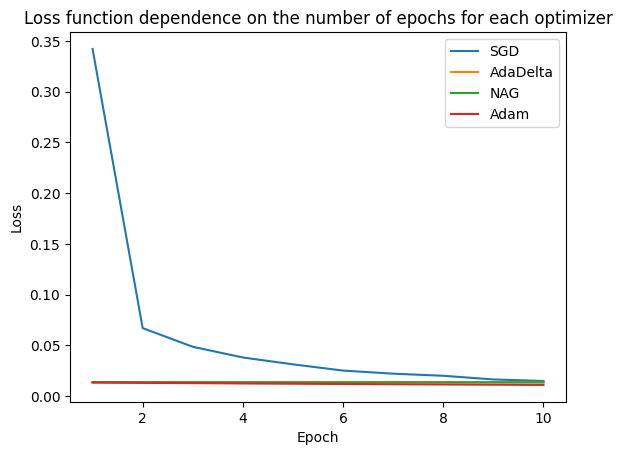

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as fctl
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.models as models

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = fctl.relu(self.conv1(x))
        x = fctl.max_pool2d(x, 2)
        x = fctl.relu(self.conv2(x))
        x = fctl.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = fctl.relu(self.fc1(x))
        x = fctl.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = LeNet()

criterion = nn.CrossEntropyLoss()

optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_adadelta = optim.Adadelta(model.parameters(), lr=0.0000001)
optimizer_nag = optim.SGD(model.parameters(), lr=0.0000001, momentum=0.9, nesterov=True)
optimizer_adam = optim.Adam(model.parameters(), lr=0.0000001)

def train_test_model(optimizer, name):
    model.train()
    losses = []
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        losses.append(epoch_loss)
        print(f"{name} - Epoch {epoch + 1} loss: {epoch_loss}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"{name} - Accuracy: {accuracy}%")

    return losses

sgd_losses = train_test_model(optimizer_sgd, "SGD")
adadelta_losses = train_test_model(optimizer_adadelta, "AdaDelta")
nag_losses = train_test_model(optimizer_nag, "NAG")
adam_losses = train_test_model(optimizer_adam, "Adam")

epochs = range(1, 11)
plt.plot(epochs, sgd_losses, label='SGD')
plt.plot(epochs, adadelta_losses, label='AdaDelta')
plt.plot(epochs, nag_losses, label='NAG')
plt.plot(epochs, adam_losses, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function dependence on the number of epochs for each optimizer')
plt.legend()
plt.show()

In [8]:
model = torchvision.models.vgg16(pretrained=False)
num_classes = 10
model.classifier[6] = nn.Linear(4096, num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
    "AdaDelta": optim.Adadelta(model.parameters(), lr=0.01),
    "NAG": optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True),
    "Adam": optim.Adam(model.parameters(), lr=0.00001)
}

for optimizer_name, optimizer in optimizers.items():
    criterion = nn.CrossEntropyLoss()
    epochs = 5

    optimizer_losses = [0] * epochs

    for epoch in range(epochs):
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            optimizer_losses[epoch] += loss.item()

        optimizer_losses[epoch] /= len(trainloader)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network with {optimizer_name} optimizer: {100 * correct / total}%")

    plt.plot(range(1, epochs + 1), optimizer_losses, label=optimizer_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss function dependence on the number of epochs for optimizer ' + optimizer_name)
    plt.legend()
    plt.show()


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

model = models.resnet34(pretrained=False)
model.to(device)
criterion = nn.CrossEntropyLoss()
accuracies = {}
optimizers = ['SGD', 'Adadelta', 'NAG', 'Adam']
losses = {optimizer_name: [] for optimizer_name in optimizers}

for optimizer_name in optimizers:
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters())
    elif optimizer_name == 'NAG':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Optimizer: {optimizer_name}, Loss: {running_loss / len(train_loader)}")
        losses[optimizer_name].append(running_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    accuracies[optimizer_name] = accuracy
    print(f'Accuracy of the network on the test images with {optimizer_name} optimizer: {accuracy:.2f}%')
    plt.plot(range(1, 6), losses[optimizer_name], label=optimizer_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss function dependence on the number of epochs for optimizer ' + optimizer_name)
    plt.legend()
    plt.show()


print("Accuracies for different optimizers:")
for optimizer_name, accuracy in accuracies.items():
    print(f"{optimizer_name}: {accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 